In [2]:
import numpy as np
from scipy.special import jnp_zeros
# import pylab as pl
import matplotlib.pyplot as pl
import matplotlib.colors as colors

In [3]:
#  T^-1 s^-1
gamma = 42.515e6 * 2*np.pi

In [4]:
def vangelderen_cylinder_perp_ln_list(D, R, DELTA, delta, G, m_max=5):
    # returns the scaling factor and the list of each summation component for ln(M(DELTA,delta,G)/M(0))
    # D:= free diffusivity in m^2 s^-1
    # R:= cylinder radius in m
    # DELTA:= gradient separation in s
    # delta:= gradient width s
    # G:= gradient magnitude in T m^-1
    am_R = jnp_zeros(1,m_max)
    am = am_R / R
    am2 = am**2
    fac = -2*gamma**2*G**2/D**2
    comp = (1/(am**6*(am_R**2-1))) * (2*D*am2*delta - 2 + 2*np.exp(-D*am2*delta) + 2*np.exp(-D*am2*DELTA) - np.exp(-D*am2*(DELTA-delta)) - np.exp(-D*am2*(DELTA+delta)))
    return fac, comp

In [5]:
def vangelderen_cylinder_perp_ln(D, R, DELTA, delta, G, m_max=5):
    fac, comp = vangelderen_cylinder_perp_ln_list(D, R, DELTA, delta, G, m_max)
    return fac*np.sum(comp)

In [6]:
def vangelderen_cylinder_perp_acq(D, R, acq, m_max=5):
    S = []
    for acqpar in acq:
        G, delta, DELTA = acqpar
        lnS = vangelderen_cylinder_perp_ln(D, R, DELTA, delta, G, m_max)
        S.append(np.exp(lnS))
    return np.array(S)

In [7]:
# acquisitions parameters
# [G, delta, DELTA] in [T/m, s, s]
acq = np.array([[300e-3, 05e-5, 40e-3],
#                 [300e-3, 10e-3, 40e-3],
                [300e-3, 20e-3, 40e-3],
#                 [300e-3, 30e-3, 40e-3],
                [300e-3, 40e-3, 40e-3]])

In [8]:
D = 2.0e-9

In [9]:
min_R = 0.4e-6/2.
max_R = 8.0e-6/2.
step_R = 0.01e-6
Rs = np.arange(min_R, max_R+step_R, step_R)

In [10]:
# generate Radius dictionary
signals = []
for R in Rs:
    S = vangelderen_cylinder_perp_acq(D, R, acq)
    signals.append(S)

In [11]:
def compute_dico_diff(S, dico, errorfunc=lambda S,gt:np.mean((np.abs(S-gt)/gt))):
    err = []
    for dico_S in dico:
        err.append(errorfunc(S,dico_S))
    return np.array(err)

In [12]:
# Test signal
RR = 0.5*3.001e-6
S = vangelderen_cylinder_perp_acq(D, RR, acq)

err_S = compute_dico_diff(S, signals)

In [13]:
tt = 0.01
ttt = np.min(err_S) + tt

In [14]:
fitted = Rs[err_S <= ttt]

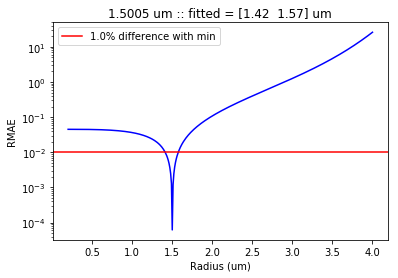

In [15]:
pl.figure()
pl.semilogy(Rs*1e6, err_S, c='b')
# pl.plot(Rs, err_S, c='b')
pl.axhline(ttt, label='{:.1f}% difference with min'.format(100*tt), c='r')
pl.title('{:.4f} um :: fitted = [{:.2f}  {:.2f}] um'.format(RR*1e6, fitted.min()*1e6, fitted.max()*1e6))
pl.legend()
pl.xlabel('Radius (um)')
pl.ylabel('RMAE')
pl.show()

In [16]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [17]:
# the default error function is too generous because it scale down with multiple times (because of mean and sensitivity skewness)
def compute_2d_slice_dico_diff(S, dico, f1, errorfunc=lambda S,gt:np.mean((np.abs(S-gt)/gt))):
    err1 = []
    for dico_S1 in dico:
        err2 = []
        for dico_S2 in dico:
            dico_S = f1*dico_S1 + (1-f1)*dico_S2
            err2.append(errorfunc(S,dico_S))
        err1.append(err2)
    return np.array(err1)

In [18]:
def plot_err(err, minV, maxV, divV):
    elev_min = minV
    elev_max = maxV
    mid_val = divV
    cmap=pl.cm.RdBu_r # set the colormap to something diverging
    fig = pl.figure()
    pl.imshow(err, cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max),extent=[(Rs*1e6).min(),(Rs*1e6).max(),(Rs*1e6).max(),(Rs*1e6).min()])
    pl.colorbar()
#     pl.show()
    return fig

In [19]:
# setting up fractions for 2 cylinders experiment
min_f = 0.
max_f = 1.
step_f = 0.05
fs = np.arange(min_f, max_f+step_f, step_f)

In [20]:
# Test signal
# shits slow and double computes because symmetry
RR1 = 0.5*3.501e-6
RR2 = 0.5*4.501e-6
ff1 = 0.35

S1 = vangelderen_cylinder_perp_acq(D, RR1, acq)
S2 = vangelderen_cylinder_perp_acq(D, RR2, acq)
S = ff1*S1 + (1-ff1)*S2

err_S = []
for f in fs:
    err_S_f = compute_2d_slice_dico_diff(S, signals, f)
    err_S.append(err_S_f)

/home/raid2/paquette/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


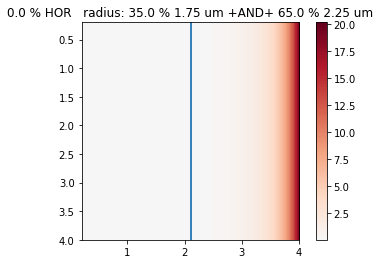

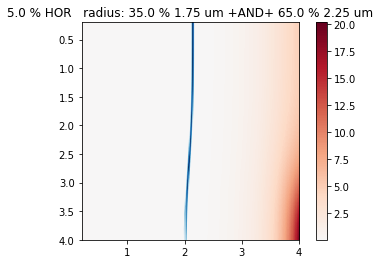

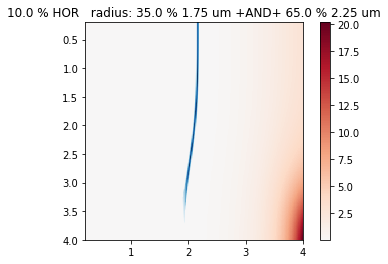

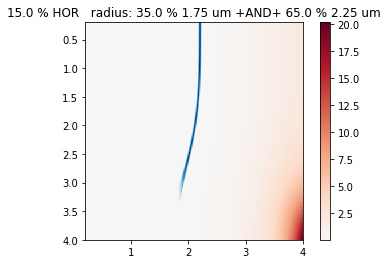

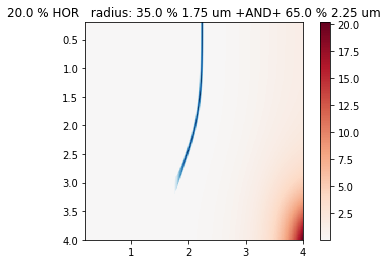

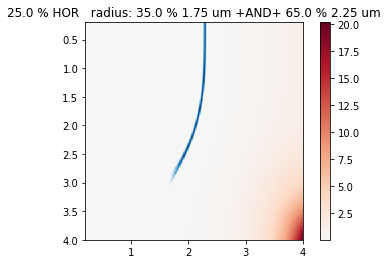

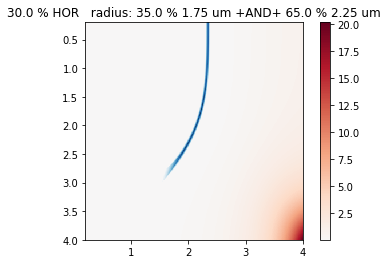

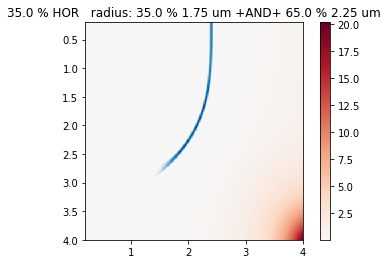

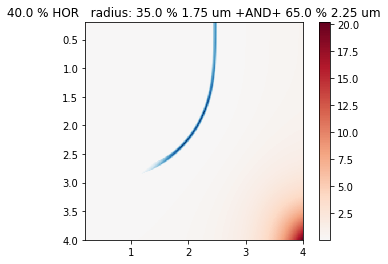

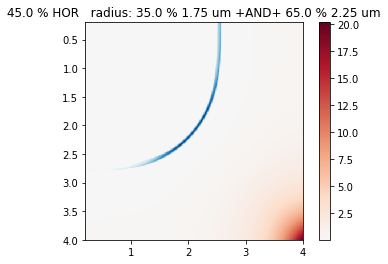

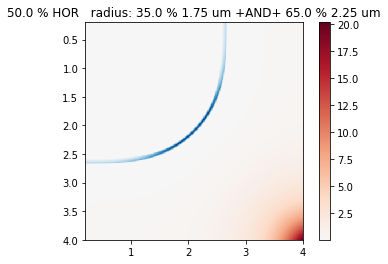

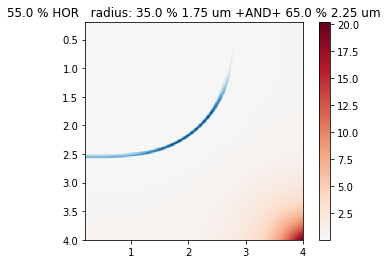

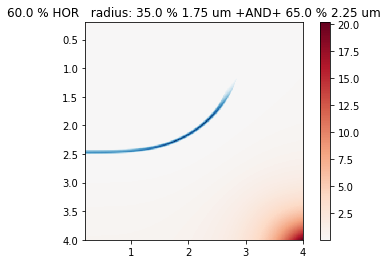

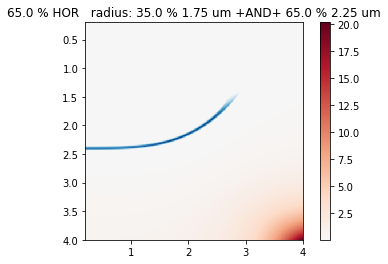

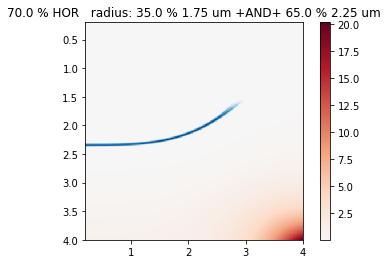

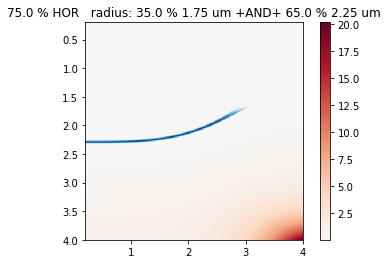

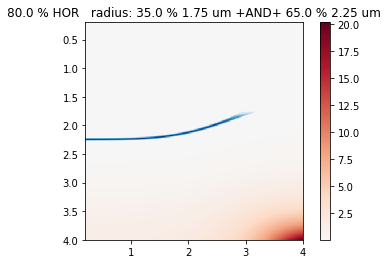

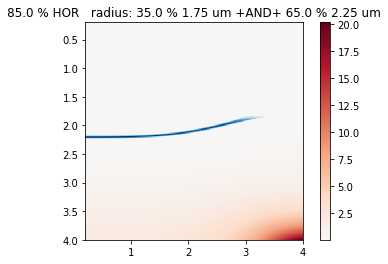

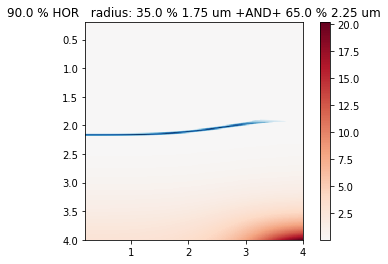

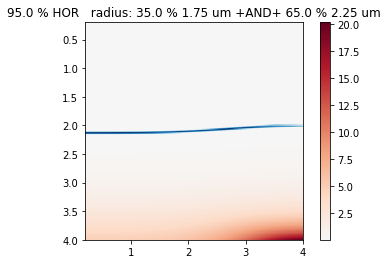

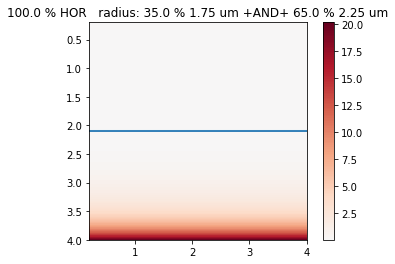

In [21]:
err_S_array = np.array(err_S)
tt = 0.01
ttt = np.min(err_S_array) + tt
minV = err_S_array.min()
maxV = err_S_array.max()

for i,f in enumerate(fs):
#     fig = plot_err(err_S[i], minV, maxV, tt)
    fig = plot_err(err_S[i], minV, maxV, ttt)
    # pl.scatter([RR*1e6], [RR*1e6], c='r')
    pl.title('{:.1f} % HOR   radius: {:.1f} % {:.2f} um +AND+ {:.1f} % {:.2f} um'.format(f*100, 100*ff1, RR1*1e6, 100*(1-ff1), RR2*1e6))
pl.show()